## 1- Preparación del Entorno


In [40]:
from funpymodeling import status
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, ConfusionMatrixDisplay
import mlflow.sklearn
import mlflow.xgboost

In [42]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
mlflow.set_experiment(experiment_name = "Churn Prediction")

2025/10/22 21:30:30 INFO mlflow.tracking.fluent: Experiment with name 'Churn Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/alumni/Programaci%C3%B3n/Proyectos/Data_Science/SimulacionLaboral/src/notebooks/mlruns/400959371580710434', creation_time=1761179430069, experiment_id='400959371580710434', last_update_time=1761179430069, lifecycle_stage='active', name='Churn Prediction', tags={}>

In [45]:
mlflow.set_tracking_uri("../../deployment/mlruns/")

### 1.1- Obtener datos

In [46]:
df = pd.read_csv("../datasets/processed_data/cleaned_data.csv") 
df.head(5)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,42,2,0.00,True,True,101348.88,True,True,False,False,True,False,True,False,False,False
1,608,41,1,83807.86,False,True,112542.58,False,False,False,True,True,False,True,False,False,False
2,502,42,8,159660.80,True,False,113931.57,True,True,False,False,True,False,False,False,True,False
3,699,39,1,0.00,False,False,93826.63,False,True,False,False,True,False,False,True,False,False
4,850,43,2,125510.82,True,True,79084.10,False,False,False,True,True,False,True,False,False,False


In [47]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,CreditScore,0,0.0,0,0.0000,460,int64
1,Age,0,0.0,0,0.0000,70,int64
2,Tenure,0,0.0,413,0.0413,11,int64
3,Balance,0,0.0,3617,0.3617,6382,float64
4,HasCrCard,0,0.0,2945,0.2945,2,bool
5,IsActiveMember,0,0.0,4849,0.4849,2,bool
6,EstimatedSalary,0,0.0,0,0.0000,9999,float64
7,Exited,0,0.0,7963,0.7963,2,bool
8,Geography_France,0,0.0,4986,0.4986,2,bool
9,Geography_Germany,0,0.0,7491,0.7491,2,bool


### 1.2- Separación en train y test

In [48]:
x = df.drop('Exited', axis=1)
y = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [49]:
x_train.shape

(8000, 16)

In [50]:
# --- Añado escalado para modeles lineales ---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

### 1.3- Balanceo de clases

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_final, y_train_final = smote.fit_resample(x_train, y_train)

In [52]:
X_train_final_linear, y_train_final_linear = smote.fit_resample(x_train_scaled, y_train)


## 2- Modelos

### 2.1- Random Forest

#### RandomizedSearchCV

In [53]:
from scipy.stats import randint

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_params = {
    "n_estimators": randint(100,300),
    "max_depth": randint(3,10),
    "min_samples_split": randint(2,10),
    "min_samples_leaf": randint(1,5),
    "bootstrap": [True, False]
}

rf_randomized = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    scoring='recall',
    random_state=42
)

rf_randomized.fit(X_train_final, y_train_final)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7b033ff50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7b03481d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7b0349150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7c6228710>},
                   random_state=42, scoring='recall')

#### GridSearchCV

In [54]:
param_grid = {
    "n_estimators": [rf_randomized.best_params_["n_estimators"] - 50, rf_randomized.best_params_["n_estimators"], rf_randomized.best_params_["n_estimators"] + 50],
    "max_depth": [rf_randomized.best_params_["max_depth"], rf_randomized.best_params_["max_depth"] + 2],
    "min_samples_split": [rf_randomized.best_params_["min_samples_split"]],
    "min_samples_leaf": [rf_randomized.best_params_["min_samples_leaf"]],
}

In [55]:
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='recall',
    verbose=1
    )

rf_grid.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'min_samples_leaf': [3],
                         'min_samples_split': [6],
                         'n_estimators': [122, 172, 222]},
             scoring='recall', verbose=1)

In [56]:
y_pred_rf = rf_grid.best_estimator_.predict(x_test)
y_prob_rf = rf_grid.best_estimator_.predict_proba(x_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_prob_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", rf_roc_auc)
print("F1: ", rf_f1)

              precision    recall  f1-score   support

       False       0.91      0.83      0.87      1607
        True       0.49      0.66      0.57       393

    accuracy                           0.80      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.83      0.80      0.81      2000

ROC AUC Score: 0.8321109459093565
F1:  0.5655471289274107


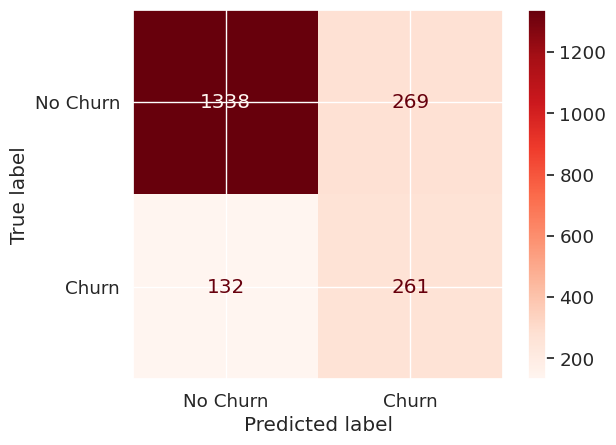

In [57]:
sns.set_theme(font_scale = 1.2)

ConfusionMatrixDisplay.from_estimator(rf_grid.best_estimator_,
                                      x_test,
                                      y_test,
                                      display_labels = ["No Churn", "Churn"],
                                      cmap = "Reds")

### 2.2- XGB Classifier

#### RandomizedSearchCV

In [58]:
xgb_params = {
    "n_estimators": randint(100,300),
    "max_depth": randint(3,10),
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [59]:
xgb_randomized = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=15,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='recall'
)

xgb_randomized.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:32] WARNING: /workspace/src/learner.cc:7

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7b067fd90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79b7c61d1f10>,
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

#### GridSearchCV

In [60]:
param_grid = {
    "n_estimators": [xgb_randomized.best_params_["n_estimators"] - 50, xgb_randomized.best_params_["n_estimators"], xgb_randomized.best_params_["n_estimators"] + 50],
    "max_depth": [xgb_randomized.best_params_["max_depth"], xgb_randomized.best_params_["max_depth"] + 2],
    "learning_rate": [xgb_randomized.best_params_["learning_rate"]],
    "subsample": [xgb_randomized.best_params_["subsample"]],
    "colsample_bytree": [xgb_randomized.best_params_["colsample_bytree"]],
}

In [61]:
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='recall',
    verbose=1
    )

xgb_grid.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:32:53] WARNING: /workspace/src/learner.cc:7

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'learning_rate': [0.2],
                         'max_depth': [9, 11], 'n_estimators': [219, 269, 319],
                         'subsample': [1.0]},
             scoring='recall', verbose=1)

In [62]:
y_pred_xgb = xgb_grid.best_estimator_.predict(x_test)
y_prob_xgb = xgb_grid.best_estimator_.predict_proba(x_test)[:, 1]

xgb_roc_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", xgb_roc_auc)
print("F1: ", xgb_f1)

              precision    recall  f1-score   support

       False       0.89      0.92      0.91      1607
        True       0.63      0.55      0.59       393

    accuracy                           0.85      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.85      0.85      2000

ROC AUC Score: 0.8395727344268317
F1:  0.5907859078590786


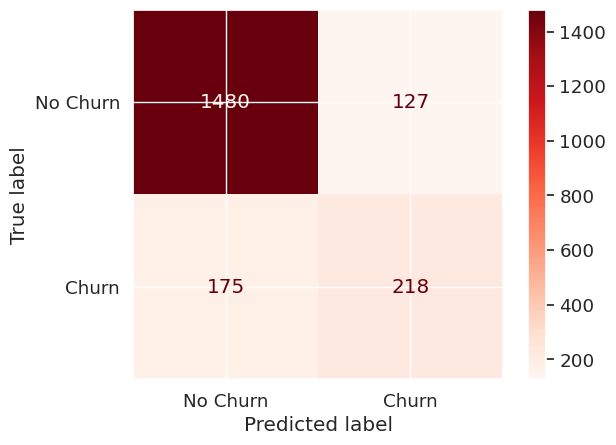

In [63]:
sns.set_theme(font_scale = 1.2)

ConfusionMatrixDisplay.from_estimator(xgb_grid.best_estimator_,
                                      x_test,
                                      y_test,
                                      display_labels = ["No Churn", "Churn"],
                                      cmap = "Reds")

### 2.3- Logistic Regression

In [64]:
from sklearn.metrics import recall_score

In [65]:
from sklearn.linear_model import LogisticRegression

#### RandomizedSearchCV

In [66]:

lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

In [67]:
from scipy.stats import uniform, loguniform # Para RandomizedSearchCV

In [68]:
random_params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': loguniform(0.01, 100),            
    'l1_ratio': uniform(0, 1)              
}

lr_randomized = RandomizedSearchCV(
    estimator=lr,
    param_distributions=random_params_lr,
    n_iter=30,          # Número de combinaciones aleatorias a probar
    cv=5,               # 5-fold cross-validation
    scoring='recall',   # Optimizar para Recall
    n_jobs=-1,          # Usar todos los procesadores
    random_state=42,
    verbose=1
)

lr_randomized.fit(X_train_final_linear, y_train_final_linear)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/alumni/Programación/Proyectos/Data_Science/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/alumni/Programación/Proyectos/Data_Sci

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1000,
                                                random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79b7c61ae750>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79b7c5f01690>,
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42, scoring='recall', verbose=1)

In [69]:

print(f"Mejores parámetros encontrados (Randomized): {lr_randomized.best_params_}")
print(f"Mejor score Recall (CV): {lr_randomized.best_score_:.4f}")

Mejores parámetros encontrados (Randomized): {'C': 0.016813042706040678, 'l1_ratio': 0.7219987722668247, 'penalty': 'l2'}
Mejor score Recall (CV): 0.7489


#### GridSearchcv

In [70]:
best_C = lr_randomized.best_params_['C']
best_penalty = lr_randomized.best_params_['penalty']

grid_params_lr = {
    'penalty': [best_penalty], # Usamos la mejor penalidad encontrada
    'C': np.linspace(max(0.001, best_C*0.5), best_C*1.5, 5), # 5 valores alrededor del mejor C
    'solver': ['saga'] # Mantenemos el solver
}

# Si la mejor penalidad fue 'elasticnet', también ajustamos l1_ratio
if best_penalty == 'elasticnet':
    best_l1 = lr_randomized.best_params_['l1_ratio']
    grid_params_lr['l1_ratio'] = np.linspace(max(0, best_l1*0.8), min(1, best_l1*1.2), 3)

lr_grid = GridSearchCV(
    estimator=lr, # Usar el mismo estimador base
    param_grid=grid_params_lr,
    cv=5,
    scoring='recall', 
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_final_linear, y_train_final_linear)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([0.00840652, 0.01260978, 0.01681304, 0.0210163 , 0.02521956]),
                         'penalty': ['l2'], 'solver': ['saga']},
             scoring='recall', verbose=1)

In [71]:
print(f"Mejores parámetros encontrados (Grid): {lr_grid.best_params_}")
print(f"Mejor score Recall (CV): {lr_grid.best_score_:.4f}")

Mejores parámetros encontrados (Grid): {'C': 0.008406521353020339, 'penalty': 'l2', 'solver': 'saga'}
Mejor score Recall (CV): 0.7503


In [72]:
y_pred_lr = lr_grid.best_estimator_.predict(x_test_scaled)
y_prob_lr = lr_grid.best_estimator_.predict_proba(x_test_scaled)[:, 1]

lr_roc_auc = roc_auc_score(y_test, y_prob_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)

print(f"Best Params: {lr_grid.best_params_}")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC: {lr_roc_auc:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"Recall: {lr_recall:.4f}")

Best Params: {'C': 0.008406521353020339, 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

       False       0.93      0.77      0.84      1607
        True       0.45      0.76      0.56       393

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.77      0.79      2000

ROC AUC: 0.8383
F1 Score: 0.5629
Recall: 0.7634


## 3- Elección del mejor modelo

In [73]:
recall_rf = recall_score(y_test, rf_grid.best_estimator_.predict(x_test))
recall_xgb = recall_score(y_test, xgb_grid.best_estimator_.predict(x_test))
recall_lr = recall_score(y_test, lr_grid.best_estimator_.predict(x_test_scaled))

models_recall = {
    "RandomForest": recall_rf,
    "XGBoost": recall_xgb,
    "LogisticRegression": recall_lr
}

best_name = max(models_recall, key=models_recall.get)

if best_name == "RandomForest":
    best_model = rf_grid.best_estimator_
    best_recall = recall_rf
elif best_name == "XGBoost":
    best_model = xgb_grid.best_estimator_
    best_recall = recall_xgb
else:
    best_model = lr_grid.best_estimator_
    best_recall = recall_lr

print(f"Recall Scores: {models_recall}")
print(f"Mejor Modelo: {best_name}")
print(f"Recall: {best_recall:.4f}")

Recall Scores: {'RandomForest': 0.6641221374045801, 'XGBoost': 0.55470737913486, 'LogisticRegression': 0.7633587786259542}
Mejor Modelo: LogisticRegression
Recall: 0.7634


In [74]:
best_model

LogisticRegression(C=0.008406521353020339, class_weight='balanced',
                   max_iter=1000, random_state=42, solver='saga')

In [75]:
from sklearn.metrics import precision_score

### Guardamos el modelo y el escalador

In [79]:
with open("../model/best_model.pkl", "wb") as handle:
    pickle.dump(best_model, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [80]:
if best_name in ["LogisticRegression"]:
    with open("../model/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

In [84]:
with mlflow.start_run(run_name=f"BestModel_{best_name}"):
    mlflow.log_param("model_type", best_name)
    if best_name == "RandomForest":
        mlflow.log_params(rf_grid.best_params_)
        recall = recall_rf
        f1 = f1_score(y_test, y_pred_rf)
        precision = precision_score(y_test, y_pred_rf)
        roc_auc = roc_auc_score(y_test, y_prob_rf)

    elif best_name == "LogisticRegression":
        mlflow.log_params(lr_grid.best_params_)
        recall = recall_lr
        f1 = f1_score(y_test, y_pred_lr)
        precision = precision_score(y_test, y_pred_lr)
        roc_auc = roc_auc_score(y_test, y_prob_lr)
        mlflow.log_artifact("../model/scaler.pkl", artifact_path="scaler")
    else:
        mlflow.log_params(xgb_grid.best_params_)
        recall = recall_xgb
        f1 = f1_score(y_test, y_pred_xgb)
        precision = precision_score(y_test, xgb_grid.best_estimator_.predict(x_test))
        roc_auc = roc_auc_score(y_test, y_prob_xgb)
    
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1_Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("ROC_AUC", roc_auc)
    mlflow.sklearn.log_model(best_model, "model")


2025/10/22 22:30:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
